ReadMe:

How to do Contrastive Learning SimCLR using Tensorflow in Colaboratory

1. Clone the dataset Imagenet.
   Refer github Code: https://github.com/thunderInfy/imagenet-5-categories

2. Prepare the images for Train and test from image paths.
3. Create TensorFlow dataset and class for data augmentation with random crops, random flips, color jitter, gaussian blur and random apply.
4. Create a data augmentation pipeline.
5. Initialize the NT_Xentloss.
6. Perform the SimCLR training and visualization with early stopping to prevent overfitting.


References:

https://github.com/sayakpaul/SimCLR-in-TensorFlow-2/blob/master/Supervised_Full_Dataset.ipynb

https://amitness.com/2020/03/illustrated-simclr/

https://github.com/sayakpaul/SimCLR-in-TensorFlow-2/blob/master/Supervised_Full_Dataset.ipynb

https://github.com/sayakpaul/SimCLR-in-TensorFlow-2/blob/imagenet-subset/SimCLR_In_TensorFlow_2-New.ipynb


In [ ]:
import tensorflow as tf

In [1]:
!nvidia-smi

Sun Sep 26 02:57:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Clone the dataset Imagenet. Refer github Code: https://github.com/thunderInfy/imagenet-5-categories

In [2]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 19.48 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [3]:
# Install wandb for experiment tracking
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

     - 10.4 MB 4.5 MB/s
     |████████████████████████████████| 180 kB 12.5 MB/s 
     |████████████████████████████████| 75 kB 3.9 MB/s 
     |████████████████████████████████| 139 kB 51.7 MB/s 
     |████████████████████████████████| 97 kB 7.0 MB/s 
     |████████████████████████████████| 70 kB 7.9 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for wandb: filename=wandb-0.8.36-py2.py3-none-any.whl size=1385054 sha256=954fbffdba7af5af370021aa7dcc1e17bef95a010052270017525a323aee2d12
  Stored in directory: /root/.cache/pip/wheels/08/1e/c2/b01dd11de70589ef2c6305c9b94da5bdfa22fd99b08da54fcf
  Created wheel for gql: filename=gql-0.2.0-py3-none-any.whl size=7639 sha256=ca50be4047639d3bf28f01f6ecb4f75970d1209e2c035489d5e9620ba5108098
  Stored in directory: /root/.cache/pip/wheels/b6/9a/56/5456fd32264a8fc53eefcb2f74e24e99a7ef4eb40a9af5c905
  Created wheel for graphql-core: filename=graphql_core-1.1-py3-none-any.whl size=104649 sha256=53e63c1ef5add8d03c2fdee26af3

In [4]:
# Imports module
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

# Other imports
import wandb
wandb.login()
from wandb.keras import WandbCallback
from tqdm import tqdm

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Prepare the images for Train and test from image paths

In [5]:
# Prepare the images for Train and test from image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [6]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [7]:
X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)

100%|██████████| 1250/1250 [00:06<00:00, 181.00it/s]


(1250, 224, 224, 3) (1250,)


100%|██████████| 250/250 [00:01<00:00, 194.44it/s]


(250, 224, 224, 3) (250,)


In [8]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

### Create TensorFlow dataset and class for data augmentation with random crops, random flips, color jitter, gaussian blur and random apply.

In [9]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train_enc))
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [10]:
class CustomAugment(object):
    def __call__(self, sample):
        # Random crops
        h = np.random.uniform(int(0.08*tf.shape(sample)[1].numpy()), tf.shape(sample)[1].numpy(), 1) 
        w = np.random.uniform(int(0.08*tf.shape(sample)[2].numpy()), tf.shape(sample)[2].numpy(), 1)
        sample = tf.image.random_crop(sample, [1, int(h), int(w), 3])
        sample = tf.image.resize(sample, size=[224, 224])
        
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)
        
        # randomly apply transformation (color distortions and blur) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)
        sample = self._random_apply(self._gaussian_blur, sample, p=0.5)

        return sample

    def _color_jitter(self, x, s=0.5):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        image = tf.image.rgb_to_grayscale(x)
        image = tf.tile(x, [1, 1, 1, 3])
        return x

    def _gaussian_blur(self, image, sigma=tf.random.uniform([], 0.1, 2.0, dtype=tf.float32),
                       padding='SAME'):
        kernel_size = image.shape[1]
        radius = tf.cast(kernel_size / 2, dtype=tf.int32)
        kernel_size = radius * 2 + 1
        
        x = tf.cast(tf.range(-radius, radius + 1), tf.float32)
        blur_filter = tf.exp(
          -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.cast(sigma, tf.float32), 2.0)))
        blur_filter /= tf.reduce_sum(blur_filter)
        
        # One vertical and one horizontal filter.
        blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
        blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
        num_channels = tf.shape(image)[-1]
        blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
        blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
        
        expand_batch_dim = image.shape.ndims == 3
        if expand_batch_dim:
            # Tensorflow requires batched input to convolutions, which we can fake with
            # an extra dimension.
            image = tf.expand_dims(image, axis=0)
        
        blurred = tf.nn.depthwise_conv2d(
            image, blur_h, strides=[1, 1, 1, 1], padding=padding)
        blurred = tf.nn.depthwise_conv2d(
            blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
        
        if expand_batch_dim:
            blurred = tf.squeeze(blurred, axis=0)
        
        blurred = tf.clip_by_value(blurred, 0., 1.)
        return blurred
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

### Create a data augmentation pipeline

In [11]:
data_augmentation = Sequential([
    Lambda(CustomAugment())
])

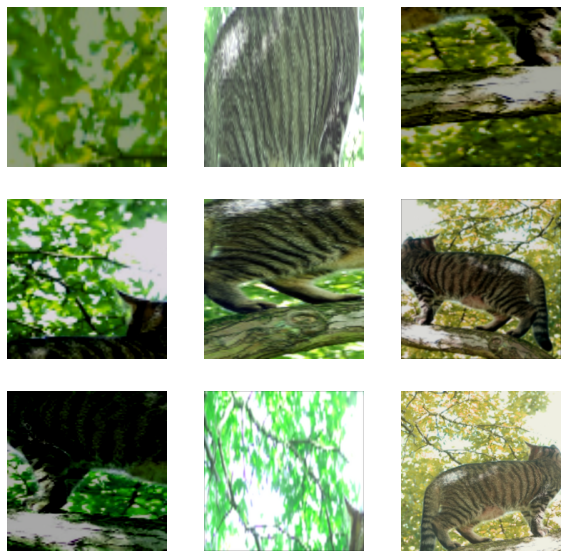

In [12]:
# Verification
idx = np.random.choice(len(train_images), 1)
sample_training_image = train_images[int(idx)]

image = plt.imread(sample_training_image)
image = cv2.resize(image, (250, 250))
image = tf.image.convert_image_dtype(image, tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(image, 0))
    plt.imshow(augmented_image[0].numpy())
    plt.axis('off')

In [13]:
# Image preprocessing utils
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[250, 250])

    return image

### Initialize the NT_Xentloss 


In [14]:
# Reference: https://github.com/google-research/simclr/blob/master/objective.py
LARGE_NUM = 1e9

def nt_xentloss(hidden_1,
		hidden_2,
		hidden_norm=True,
		temperature=1.0,
		weights=1.0):
  
	# Get (normalized) hidden1 and hidden2.
	if hidden_norm:
		hidden_1 = tf.math.l2_normalize(hidden_1, -1)
		hidden_2 = tf.math.l2_normalize(hidden_2, -1)
	# hidden1, hidden2 = tf.split(hidden, 2, 0)
	batch_size = tf.shape(hidden_1)[0]

	hidden1_large = hidden_1
	hidden2_large = hidden_2
	labels = tf.one_hot(tf.range(batch_size), batch_size * 2)
	masks = tf.one_hot(tf.range(batch_size), batch_size)

	logits_aa = tf.matmul(hidden_1, hidden1_large, transpose_b=True) / temperature
	logits_aa = logits_aa - masks
	logits_bb = tf.matmul(hidden_2, hidden2_large, transpose_b=True) / temperature
	logits_bb = logits_bb - masks 
	logits_ab = tf.matmul(hidden_1, hidden2_large, transpose_b=True) / temperature
	logits_ba = tf.matmul(hidden_2, hidden1_large, transpose_b=True) / temperature

	loss_a = tf.compat.v1.losses.softmax_cross_entropy(
		labels, tf.concat([logits_ab, logits_aa], 1), weights=weights)
	loss_b = tf.compat.v1.losses.softmax_cross_entropy(
		labels, tf.concat([logits_ba, logits_bb], 1), weights=weights)
	loss = loss_a + loss_b

	return loss, logits_ab, labels

In [15]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainabe = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)

    resnet_simclr = Model(inputs, projection_2)

    return resnet_simclr

In [16]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

### Perform the SimCLR training and visualization with with early stopping to prevent overfitting.


In [17]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

In [20]:
get_resnet_simclr(512, 256).summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
Total params: 24,768,128
Trainable params: 24,715,008
Non-trainable params: 53,120
____________________________________________

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Streaming file created twice in same run: /content/wandb/run-20210926_030104-supervised-training/wandb-history.jsonl
Streaming file created twice in same run: /content/wandb/run-20210926_030104-supervised-training/wandb-events.jsonl


Epoch 1/50
20/20 [==============================] - 71s 2s/step - loss: 12.4595 - accuracy: 0.1896 - val_loss: 11.9749 - val_accuracy: 0.2000


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
20/20 [==============================] - 27s 1s/step - loss: 11.6061 - accuracy: 0.2000 - val_loss: 11.2803 - val_accuracy: 0.2000
Epoch 3/50
20/20 [==============================] - 27s 1s/step - loss: 11.2106 - accuracy: 0.2000 - val_loss: 11.0573 - val_accuracy: 0.2000
Epoch 4/50
20/20 [==============================] - 27s 1s/step - loss: 8.3355 - accuracy: 0.2000 - val_loss: 8.0567 - val_accuracy: 0.2000
Epoch 5/50
20/20 [==============================] - 26s 1s/step - loss: 8.0567 - accuracy: 0.1600 - val_loss: 8.0567 - val_accuracy: 0.1600
Epoch 6/50
20/20 [==============================] - 26s 1s/step - loss: 8.0567 - accuracy: 0.1664 - val_loss: 8.0567 - val_accuracy: 0.1600
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


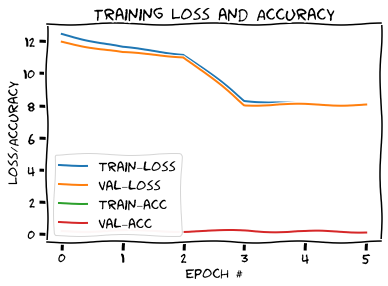

In [22]:
# Train the supervised model with full data
wandb.init(project="simclr", id="supervised-training")

model = get_resnet_simclr(512, 256)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
              optimizer=tf.keras.optimizers.Adam(1e-3))
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=50,
                    callbacks=[es, WandbCallback()])
plot_training(history)